<a href="https://colab.research.google.com/github/btcnhung1299/tf-practice/blob/master/TXT_SarcasmDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

## Data Gathering

In [2]:
!wget https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json

--2020-09-27 08:09:01--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.111.128, 74.125.126.128, 173.194.195.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.111.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5643545 (5.4M) [application/json]
Saving to: ‘sarcasm.json’

sarcasm.json        100%[===================>]   5.38M  --.-KB/s    in 0.06s   

2020-09-27 08:09:01 (86.7 MB/s) - ‘sarcasm.json’ saved [5643545/5643545]



In [3]:
df = pd.read_json("./sarcasm.json")
df.head()

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


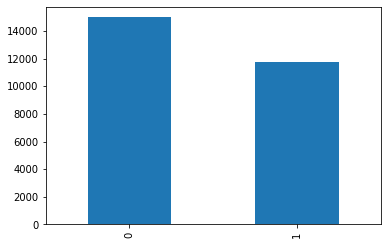

In [4]:
df["is_sarcastic"].value_counts().plot(kind="bar");

In [5]:
texts = df["headline"].values
labels = df["is_sarcastic"].values

## Data Preparation

### Tokenization

In [6]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [7]:
VOCAB_SIZE = 10000
tokenizer = Tokenizer(VOCAB_SIZE, oov_token="<OOV>")
tokenizer.fit_on_texts(texts)

### Create samples

In [8]:
df["headline"].apply(lambda x : len(x)).describe()

count    26709.000000
mean        60.910629
std         19.184423
min          7.000000
25%         48.000000
50%         61.000000
75%         73.000000
max        254.000000
Name: headline, dtype: float64

In [9]:
MAX_SEQ_LEN = 128
BUFFER_SIZE = 1024

text_ids = pad_sequences(tokenizer.texts_to_sequences(texts), maxlen=MAX_SEQ_LEN, padding="post")
samples = tf.data.Dataset.from_tensor_slices((text_ids, labels)).shuffle(BUFFER_SIZE)

### Create dataset

In [10]:
BATCH_SIZE = 64

test_size = 0.2
num_samples = sum(1 for x in samples)
num_train_samples = int(test_size * num_samples)
ds_train = samples.take(num_train_samples).batch(BATCH_SIZE)
ds_val = samples.skip(num_train_samples).batch(BATCH_SIZE)

## Model Architecture

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dropout, GlobalAveragePooling1D, Dense, GlobalMaxPooling1D

In [12]:
EMBED_DIM = 32

model = Sequential()
model.add(Embedding(input_dim=VOCAB_SIZE, output_dim=EMBED_DIM))
model.add(GlobalAveragePooling1D())
model.add(Dropout(0.3))
model.add(Dense(1, activation="sigmoid"))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 32)          320000    
_________________________________________________________________
global_average_pooling1d (Gl (None, 32)                0         
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 320,033
Trainable params: 320,033
Non-trainable params: 0
_________________________________________________________________


In [13]:
model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["acc"])

In [14]:
history = model.fit(ds_train, epochs=60, validation_data=ds_val)

Epoch 1/60
84/84 [==============================] - 1s 14ms/step - loss: 0.6879 - acc: 0.5510 - val_loss: 0.6845 - val_acc: 0.5610
Epoch 2/60
84/84 [==============================] - 1s 12ms/step - loss: 0.6831 - acc: 0.5630 - val_loss: 0.6821 - val_acc: 0.5614
Epoch 3/60
84/84 [==============================] - 1s 12ms/step - loss: 0.6809 - acc: 0.5617 - val_loss: 0.6800 - val_acc: 0.5611
Epoch 4/60
84/84 [==============================] - 1s 12ms/step - loss: 0.6787 - acc: 0.5589 - val_loss: 0.6772 - val_acc: 0.5615
Epoch 5/60
84/84 [==============================] - 1s 12ms/step - loss: 0.6749 - acc: 0.5598 - val_loss: 0.6740 - val_acc: 0.5612
Epoch 6/60
84/84 [==============================] - 1s 12ms/step - loss: 0.6708 - acc: 0.5581 - val_loss: 0.6694 - val_acc: 0.5622
Epoch 7/60
84/84 [==============================] - 1s 12ms/step - loss: 0.6642 - acc: 0.5636 - val_loss: 0.6648 - val_acc: 0.5611
Epoch 8/60
84/84 [==============================] - 1s 12ms/step - loss: 0.6581 - a

In [15]:
model.evaluate(ds_val)

334/334 [==============================] - 1s 2ms/step - loss: 0.3785 - acc: 0.8325


[0.37846922874450684, 0.832506537437439]

### Transfer learning w. pretrained embedding

*Train and test set is not the same for each approach :(*

In [16]:
BATCH_SIZE = 64
BUFFER_SIZE = 1024

samples = tf.data.Dataset.from_tensor_slices((texts, labels)).shuffle(BUFFER_SIZE)
num_samples = sum(1 for x in samples)
test_size = 0.2
num_train_samples = int(test_size * num_samples)

ds_train = samples.take(num_train_samples).batch(BATCH_SIZE)
ds_val = samples.skip(num_train_samples).batch(BATCH_SIZE)

In [20]:
import tensorflow_hub as hub
embedding_url = "https://tfhub.dev/google/universal-sentence-encoder-large/5"

model = Sequential()
model.add(hub.KerasLayer(embedding_url, input_shape=(), dtype=tf.string, trainable=True))
model.add(Dropout(0.5))
model.add(Dense(1, activation="sigmoid"))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 512)               147354880 
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 513       
Total params: 147,355,393
Trainable params: 147,355,393
Non-trainable params: 0
_________________________________________________________________


In [21]:
model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["acc"])
model.fit(ds_train, epochs=2, validation_data=ds_val);

Epoch 1/2
84/84 [==============================] - 39s 467ms/step - loss: 0.4480 - acc: 0.8040 - val_loss: 0.4023 - val_acc: 0.8351
Epoch 2/2
84/84 [==============================] - 35s 422ms/step - loss: 0.2506 - acc: 0.9186 - val_loss: 0.3190 - val_acc: 0.8715


In [22]:
model.evaluate(ds_val)

334/334 [==============================] - 14s 43ms/step - loss: 0.3199 - acc: 0.8710


[0.3198675811290741, 0.87102210521698]